In [12]:
import os
import gc
import optuna
import warnings
import numpy as np
from utils import *
import pandas as pd
from copy import deepcopy
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from train_models import get_model_scores
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
warnings.filterwarnings('ignore')
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/clean_skills_v2.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/clean_language.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/clean_education_v2.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6
    study_size = 50
    school_size = 50
    language_size = 8
    degree_size = 40
    skill_size = 120
    skill_exact_match =  False
    degree_exact_match =  True
    school_exact_match =  True
    study_exact_match =  True

In [13]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)
#df.loc[df['industry'] == '-1', 'industry'] = np.nan
df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [14]:
def fix_location(dataframe: pd.DataFrame, feature: str = 'location') -> pd.DataFrame:

    tr_cities = load_tr_cities()
    df_ = dataframe.copy()
    df_.loc[df_[feature].astype(str).str.contains('Kahraman Maras'), feature] = 'Kahramanmaras, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Şanliurfa'), feature] = 'Sanliurfa, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('İçel'), feature] = 'Mersin, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Afyon'), feature] = 'Afyonkarahisar, Turkey'
    df_[feature] = df_[feature].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_[feature] = df_[feature].apply(lambda x: x.upper().strip())
    df_[feature] = df_[feature].apply(lambda x: translation(str(x)))
    for city in tr_cities:
        df_[feature] = df_[feature].apply(lambda x: city if city in x else x)
    df_[f'{feature}_based_on_tr'] = df_[feature].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)
        
    return df_

skills_df = load_skills(config.skills_path, config.skill_size, exact_match=config.skill_exact_match)
school_df = load_school(config.education_path, config.school_size, exact_match = config.school_exact_match)
degree_df = load_degree(config.education_path, config.degree_size, exact_match = config.degree_exact_match)
study_df = load_study(config.education_path, config.study_size, exact_match = config.study_exact_match)
lang_df = load_languages(config.languages_path, config.language_size)
exp_df = load_work_experiences(config.exp_path)

df = fix_location(df)
df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(school_df, on = ['user_id'], how = 'left')
df = df.merge(degree_df, on = ['user_id'], how = 'left')
df = df.merge(study_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')
df = add_populations(df)
#df = add_employment(df)

df['nunique_company_by_industries'] = df.groupby(by = 'industry')['company_id'].transform('nunique')
df['active_employees_by_companies'] = df.groupby(by = 'company_id')['user_id'].transform('nunique')
df['nunique_industries_by_companies'] = df.groupby(by = 'company_id')['industry'].transform('nunique')

#df['active_employees_by_industries'] = df.groupby(by = 'industry')['user_id'].transform('nunique')
#df['nunique_locations_by_industries'] = df.groupby(by = 'industry')['location'].transform('nunique')

train_df = df.loc[df['moved_after_2019'].notnull()]
test_df = df.loc[df['moved_after_2019'].isnull()]
train_df, test_df = label_encode(["company_id", 'location'], train_df, test_df, fillna=True)
df = train_df.append(test_df).reset_index(drop = True)

print(df.shape)
df.head()

100%|██████████| 50/50 [00:01<00:00, 32.46it/s]


(66274, 309)


,user_id,industry,location,moved_after_2019,location_based_on_tr,skill_.net,skill_administration,skill_agile,skill_agile methodologies,skill_ajax,...,company_nunique_employees,company_lifetime,company_last_hire,avg_days_to_quit_diff,avg_days_to_quit_ratio,company_hire_ratio,population,nunique_company_by_industries,active_employees_by_companies,nunique_industries_by_companies
0,1301,Information Technology and Services,48.0,1.0,1,0.0,0.0,1.0,1.0,0.0,...,1410.0,11902.0,31.0,465.280537,2.040896,8.441135,15907951.0,3285.0,665.0,28.0
1,6950,Internet,48.0,0.0,1,0.0,0.0,0.0,0.0,0.0,...,66.0,1887.0,61.0,-131.480769,0.749680,28.590909,15907951.0,744.0,53.0,6.0
2,4880,Online Media,100.0,0.0,1,0.0,0.0,0.0,0.0,1.0,...,4.0,610.0,610.0,NaN,NaN,152.500000,NaN,32.0,4.0,1.0
3,26046,Telecommunications,48.0,0.0,1,0.0,0.0,0.0,0.0,0.0,...,1410.0,11902.0,31.0,-2496.719463,0.267609,8.441135,15907951.0,680.0,665.0,28.0
4,11005,Banking,48.0,0.0,1,1.0,0.0,0.0,0.0,0.0,...,678.0,5235.0,31.0,-299.166667,0.736726,7.721239,15907951.0,429.0,402.0,17.0


In [15]:
#def fill_industry_with_skills(dataframe: pd.DataFrame, skills_dataframe: pd.DataFrame) -> pd.DataFrame:
#
#    df_ = dataframe.copy()
#    skills_df_ = skills_dataframe.copy()
#
#    non_missing_df = df_.loc[df_["industry"].notnull()][
#        [col for col in skills_df_.columns] + ["industry"]
#    ].dropna(subset=[col for col in df_.columns if col.startswith("skill")])
#
#    search_df = df_.loc[df_["industry"].isnull()][
#        [col for col in skills_df_.columns] + ["industry"]
#    ].dropna(subset=[col for col in df_.columns if col.startswith("skill")])[
#        non_missing_df.columns
#    ]
#    
#    match_results = dict()
#    for idx, row in search_df.iterrows():
#        employee = row['user_id']
#        missing_data_point = [row[col] for col in search_df.columns if col not in ['user_id', 'industry']]
#        manhattan_dist = np.abs(non_missing_df.drop(columns = ['user_id', 'industry'], axis = 1) - missing_data_point).sum(axis=1)
#        match_df = non_missing_df.assign(dist=manhattan_dist).copy()
#
#        if manhattan_dist.min() < 3:
#            i = 1
#            while i < 20:
#                avg_dist = match_df.sort_values("dist")[:i]["dist"].mean()
#                if avg_dist > 4.25:
#                    break
#                match_industry = match_df.sort_values("dist")[:i]["industry"].mode().values[0]
#                i += 1
#            match_results[employee] = match_industry
#        else:
#            match_industry = match_df.sort_values("dist")["industry"].values[0]
#            match_results[employee] = match_industry
#            continue
#        
#        del match_df
#        gc.collect()
#
#    print(f'industry matches: {len(match_results)}')
#    for key in match_results.keys():
#        df_.loc[df_['user_id'] == key, 'industry'] = match_results[key]
#
#    return df_
#
#print(f"industry missing values: {df['industry'].isnull().sum()}")
#df = fill_industry_with_skills(df, skills_df)
#df['industry'] = df['industry'].fillna('Computer Software')
#df['location'] = df['location'].fillna('ISTANBUL')
#print(f"industry missing values: {df['industry'].isnull().sum()}")

#from kmodes.kmodes import KModes
#
#cluster = KModes(n_clusters=6, n_jobs=-1)
#
#df['kmodes_label'] = cluster.fit_predict(df[[col for col in df.columns if 
#                        col.startswith('skill') or
#                        col.startswith('degree') or
#                        col.startswith('study') or
#                        col.startswith('language')]].fillna(0))


#df.head()

In [16]:
check_missing(df)[:20]

,feature,n_missing,missing_rate
282,employee_std_days_to_quit,43234,0.652352
298,company_skew_days_to_quit,29310,0.442255
280,employee_min_days_to_quit,29249,0.441334
283,employee_med_days_to_quit,29249,0.441334
281,employee_max_days_to_quit,29249,0.441334
279,employee_last_days_to_quit,29249,0.441334
134,total_languages,28984,0.437336
132,language_spanish,28984,0.437336
126,language_arabic,28984,0.437336
131,language_russian,28984,0.437336


In [17]:
#df[['total_degrees', target]].corr()

In [18]:
target = 'moved_after_2019'
cat_features = ['industry', 'location', 'company_id',
                'employee_last_experience_year',
                'employee_last_experience_month',
                #'employee_last_location',
                #'company_2th_id', 'company_3th_id'
                'employee_first_experience_year',
                #'employee_first_experience_month'
                ]
drop_features = ['user_id']

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 308)
test_set: (13255, 308)


In [19]:
train_set.corr()[target].abs().sort_values(ascending=False)[1:21]

employee_lifetime                     0.190762
employee_avg_days_to_quit             0.177762
employee_last_experience              0.172652
avg_days_to_quit_diff                 0.161060
company_count_2018                    0.151162
employee_max_days_to_quit             0.122409
employee_med_days_to_quit             0.117541
employee_last_days_to_quit            0.112801
degree_bachelor's degree              0.103590
skill_python                          0.101896
avg_days_to_quit_ratio                0.096563
skill_git                             0.092097
employee_min_days_to_quit             0.086788
employee_total_experience             0.085865
company_count_2017                    0.084784
company_lifetime                      0.080494
employee_std_days_to_quit             0.078642
skill_teamwork                        0.078586
employee_last_experience_month_cos    0.078383
company_max_days_to_quit              0.077222
Name: moved_after_2019, dtype: float64

In [20]:
train_set.corr()[target].abs().sort_values(ascending=False)[21:41]

company_avg_days_to_quit                0.072991
company_std_days_to_quit                0.071139
skill_programming                       0.067341
skill_c                                 0.062543
skill_docker                            0.061913
skill_software engineering              0.060335
active_employees_by_companies           0.060164
skill_learning                          0.058148
skill_c++                               0.057707
skill_matlab                            0.057317
skill_html                              0.056215
skill_machine learning                  0.056100
company_hire_ratio                      0.055728
skill_css                               0.054698
company_last_hire                       0.054693
skill_object oriented programming       0.053153
skill_oriented programming              0.053115
fields_of_study_computer engineering    0.053028
skill_machine                           0.052473
company_nunique_employees               0.052213
Name: moved_after_20

In [21]:
cat1 = CatBoostClassifier(
    **{
        "one_hot_max_size": 150,
        "depth": 12,
        "learning_rate": 0.02,
        "boosting_type": "Plain",
        "bootstrap_type": "MVS",
        "iterations": 4000,
        "random_state": config.seed,
        "cat_features": cat_features,
        "eval_metric": "Accuracy",
        "allow_writing_files": False,
        "verbose": False,
    }
)

cat2 = CatBoostClassifier(
    **{
        "one_hot_max_size": 138,
        "depth": 11,
        'learning_rate': 0.0175,
        "boosting_type": "Plain",
        "bootstrap_type": "Bernoulli",
        'subsample': 0.81,
        "iterations": 5000,
        "random_state": config.seed,
        "cat_features": cat_features,
        "eval_metric": "Accuracy",
        "allow_writing_files": False,
        "verbose": False,
    }
)

xgb1 = XGBClassifier(
    **{
        "max_depth": 12,
        "subsample": 0.84,
        "learning_rate": 0.012,
        "enable_categorical": True,
        "random_state": config.seed,
        "tree_method": "hist",
        "n_estimators": 5000,
    }
)

xgb2 = XGBClassifier(
    **{
        "max_depth": 11,
        "learning_rate": 0.015238768735012887,
        "subsample": 0.8023883794058948,
        "tree_method": "hist",
        "enable_categorical": True,
        "random_state": config.seed,
        "n_estimators": 5000,
        "objective": "binary:logistic",
    }
)

kf = KFold(n_splits=config.n_folds, shuffle=True, random_state=config.seed)

skf = StratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=config.seed)


-----------------------------------| Fold 1 |-----------------------------------
train: (44182, 307)
val: (8837, 307)
[0]	validation_0-logloss:0.69018
[250]	validation_0-logloss:0.54180
[500]	validation_0-logloss:0.51008
[750]	validation_0-logloss:0.48936
[1000]	validation_0-logloss:0.47406
[1250]	validation_0-logloss:0.46337
[1500]	validation_0-logloss:0.45639
[1750]	validation_0-logloss:0.45185
[2000]	validation_0-logloss:0.44995
[2250]	validation_0-logloss:0.44881
[2500]	validation_0-logloss:0.44908
[2750]	validation_0-logloss:0.44964
[2831]	validation_0-logloss:0.44994


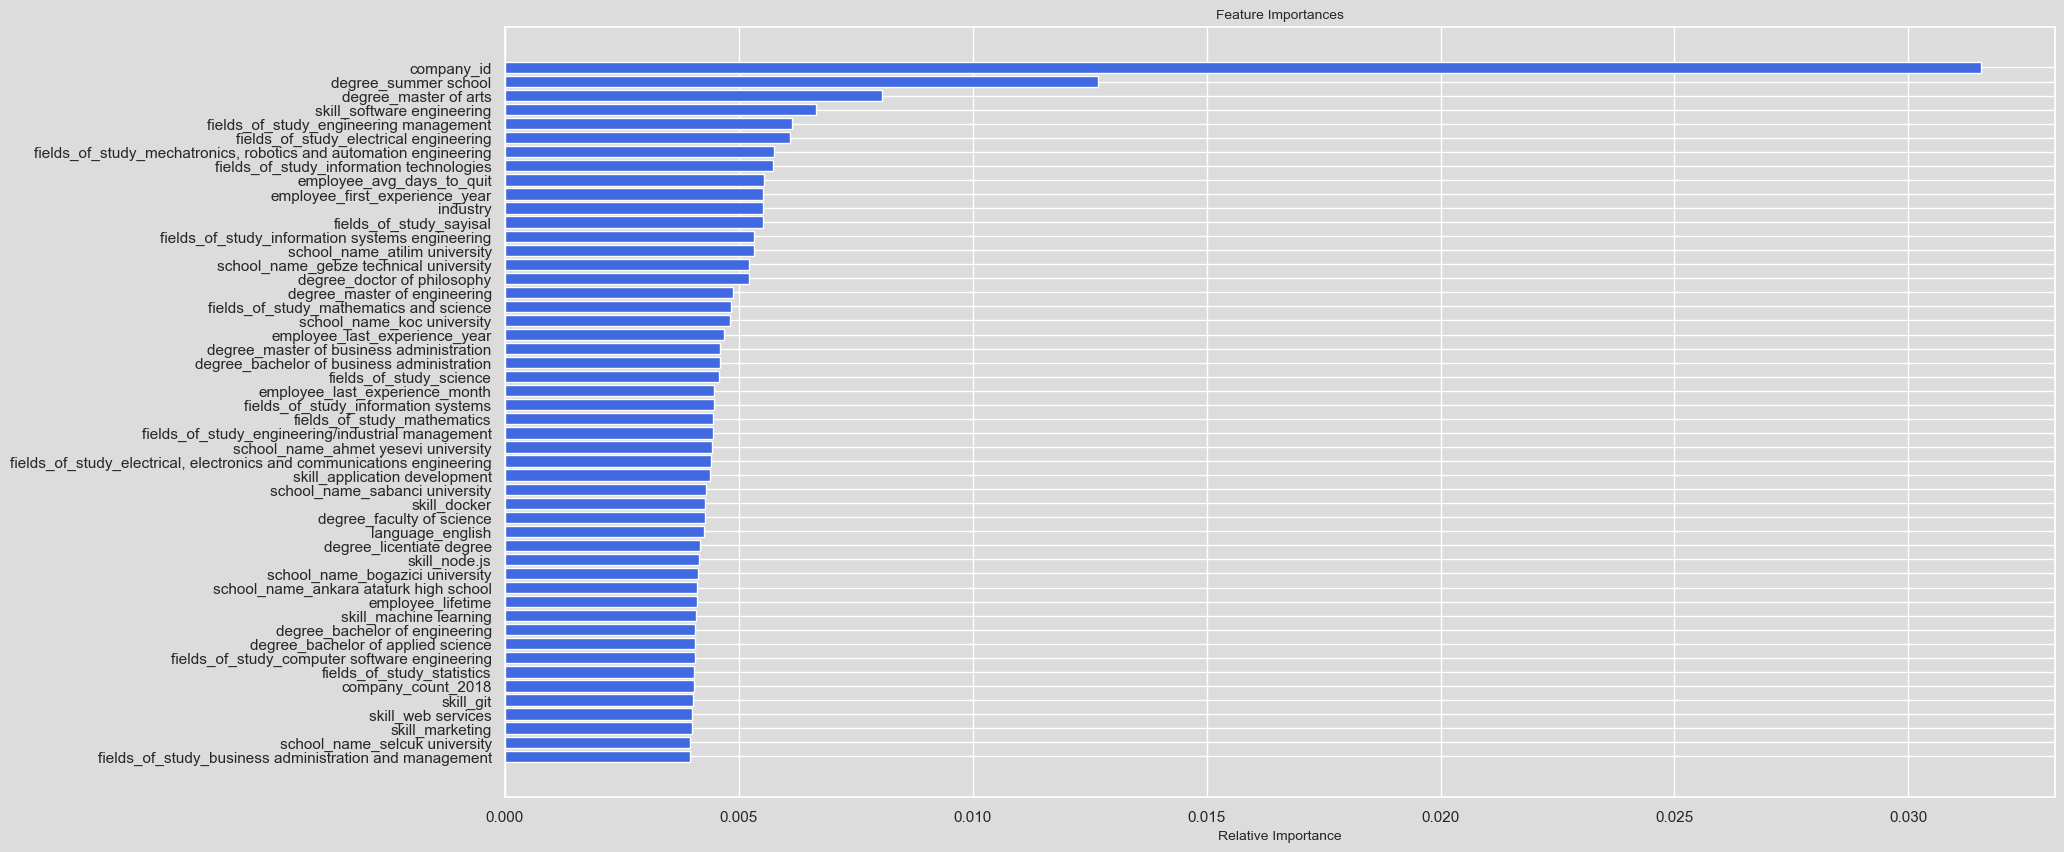

fold accuracy: 0.7871449586963902
-----------------------------------| Fold 2 |-----------------------------------
train: (44182, 307)
val: (8837, 307)
[0]	validation_0-logloss:0.69023
[250]	validation_0-logloss:0.53845
[500]	validation_0-logloss:0.50811
[750]	validation_0-logloss:0.48755
[1000]	validation_0-logloss:0.47154
[1250]	validation_0-logloss:0.46066
[1500]	validation_0-logloss:0.45311
[1750]	validation_0-logloss:0.44850
[2000]	validation_0-logloss:0.44601
[2250]	validation_0-logloss:0.44514
[2500]	validation_0-logloss:0.44460
[2750]	validation_0-logloss:0.44525
[2994]	validation_0-logloss:0.44653


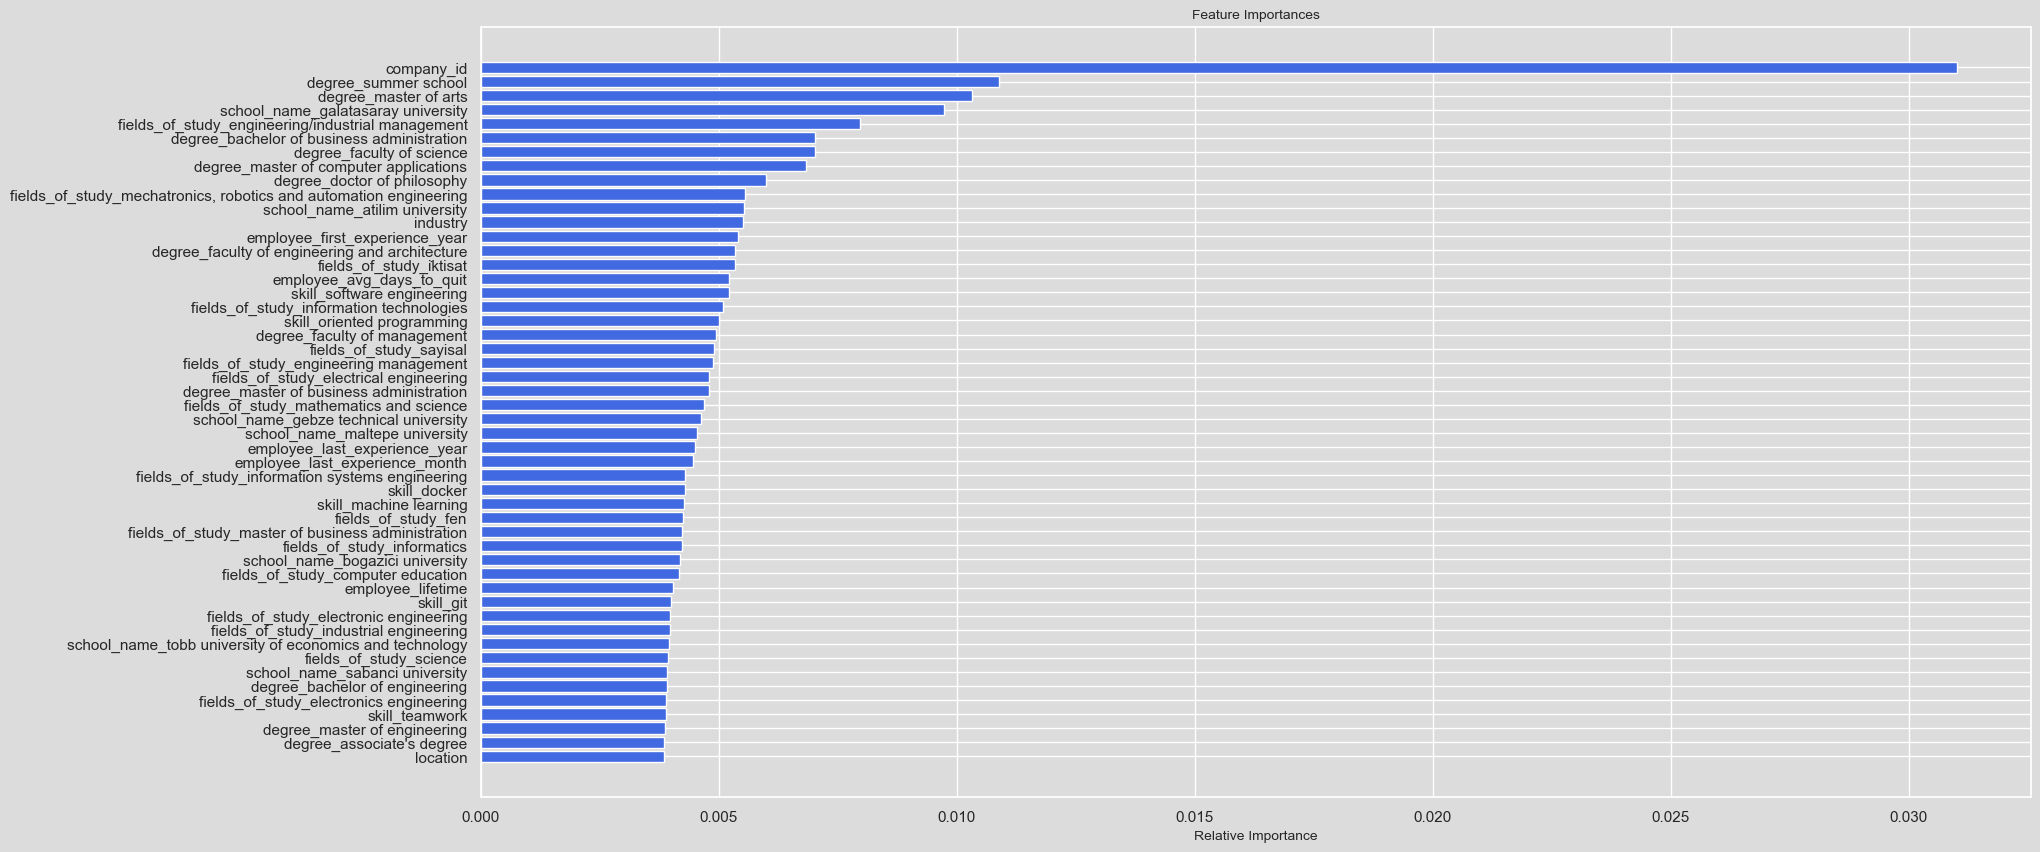

fold accuracy: 0.7871449586963902
-----------------------------------| Fold 3 |-----------------------------------
train: (44182, 307)
val: (8837, 307)
[0]	validation_0-logloss:0.69011
[250]	validation_0-logloss:0.53857
[500]	validation_0-logloss:0.50866
[750]	validation_0-logloss:0.48827
[1000]	validation_0-logloss:0.47298
[1250]	validation_0-logloss:0.46247
[1500]	validation_0-logloss:0.45576
[1750]	validation_0-logloss:0.45218
[2000]	validation_0-logloss:0.44980
[2250]	validation_0-logloss:0.44836
[2500]	validation_0-logloss:0.44831
[2750]	validation_0-logloss:0.44918
[2803]	validation_0-logloss:0.44944


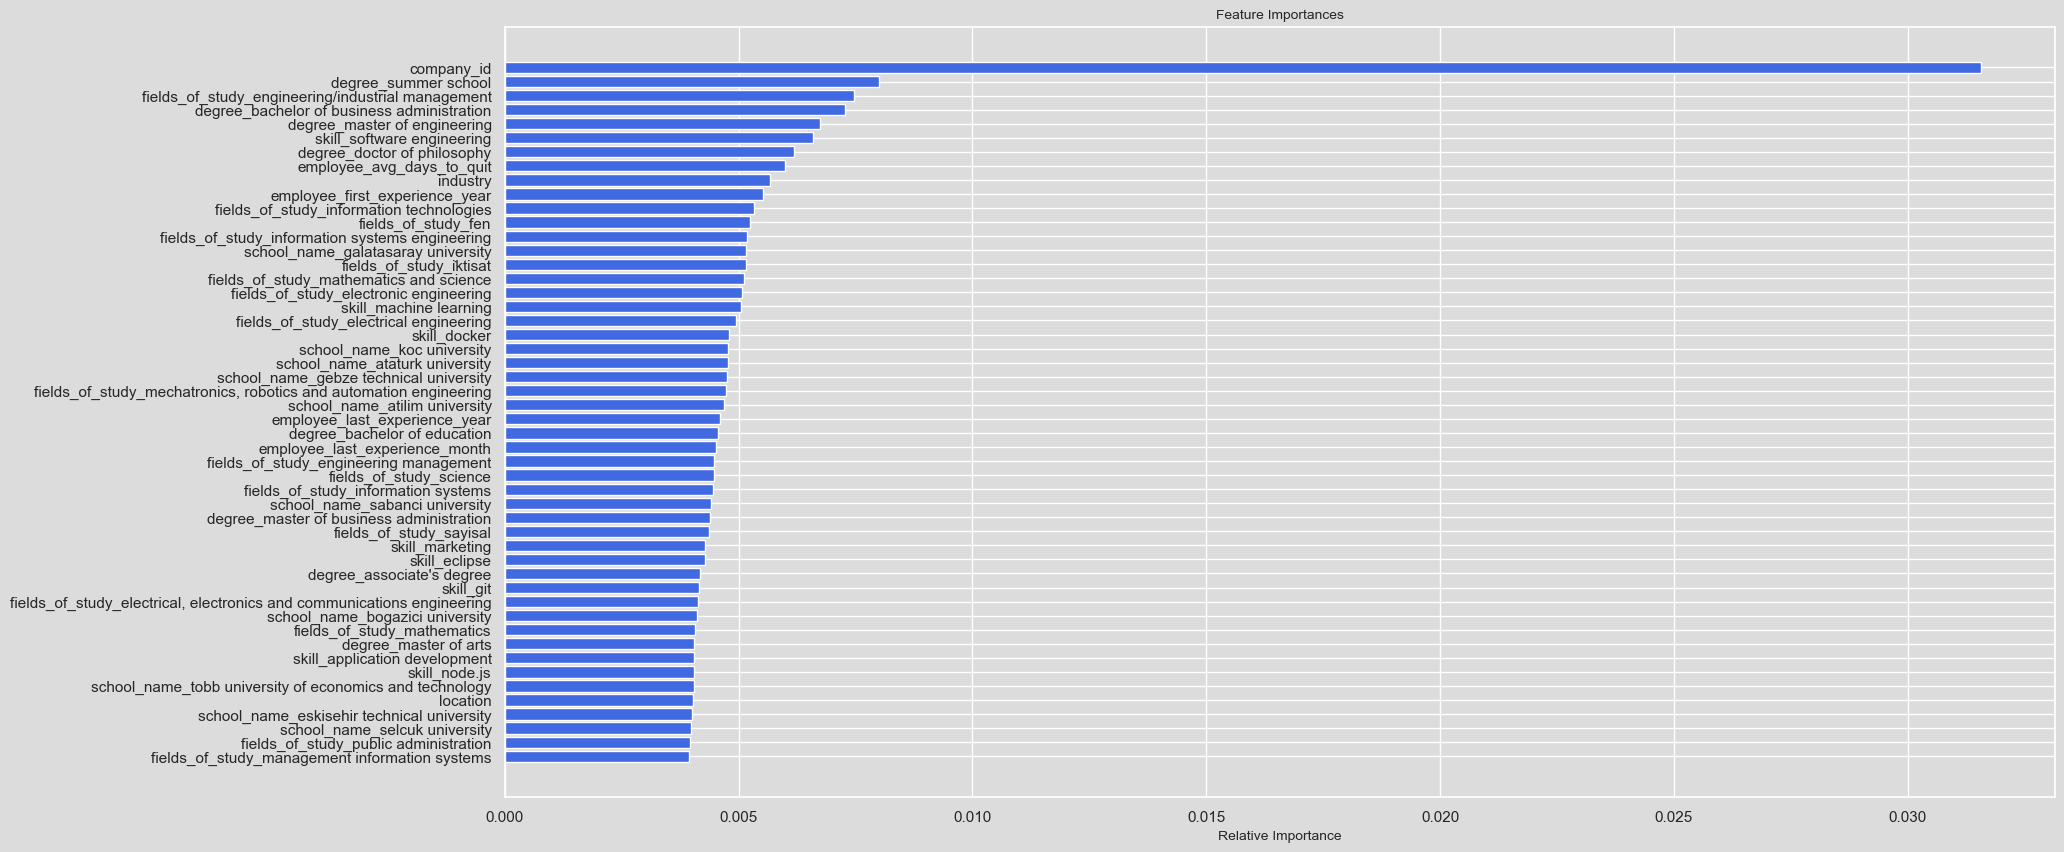

fold accuracy: 0.7789973973067783
-----------------------------------| Fold 4 |-----------------------------------
train: (44183, 307)
val: (8836, 307)
[0]	validation_0-logloss:0.69023
[250]	validation_0-logloss:0.53881
[500]	validation_0-logloss:0.51066
[750]	validation_0-logloss:0.49108
[1000]	validation_0-logloss:0.47659


KeyboardInterrupt: 

In [22]:
xgb2_scores, xgb2_train_scores = get_model_scores(xgb2, skf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #accuracy: 0.7895094211509082

accuracy: 0.7904336181368943 <br>
folds avg accuracy: 0.7904335839357636

-----------------------------------| Fold 1 |-----------------------------------
train: (46391, 301)
val: (6628, 301)
0:	learn: 0.6438749	test: 0.6341279	best: 0.6341279 (0)	total: 253ms	remaining: 21m 2s
250:	learn: 0.7769610	test: 0.7392879	best: 0.7397405 (249)	total: 35.2s	remaining: 11m 6s
500:	learn: 0.8172706	test: 0.7516596	best: 0.7521123 (469)	total: 1m 14s	remaining: 11m 13s
750:	learn: 0.8545408	test: 0.7616174	best: 0.7623718 (738)	total: 1m 51s	remaining: 10m 30s
1000:	learn: 0.8907116	test: 0.7685576	best: 0.7697646 (964)	total: 2m 32s	remaining: 10m 9s
1250:	learn: 0.9166864	test: 0.7744418	best: 0.7753470 (1236)	total: 3m 14s	remaining: 9m 43s
1500:	learn: 0.9350089	test: 0.7761014	best: 0.7761014 (1483)	total: 3m 52s	remaining: 9m 2s
1750:	learn: 0.9491712	test: 0.7815329	best: 0.7815329 (1749)	total: 4m 30s	remaining: 8m 21s
2000:	learn: 0.9597551	test: 0.7822873	best: 0.7831925 (1978)	total: 5m 7s	remaining: 7m 40s
2250:	learn: 0.9685068	test: 0.7840978	best: 0.7851

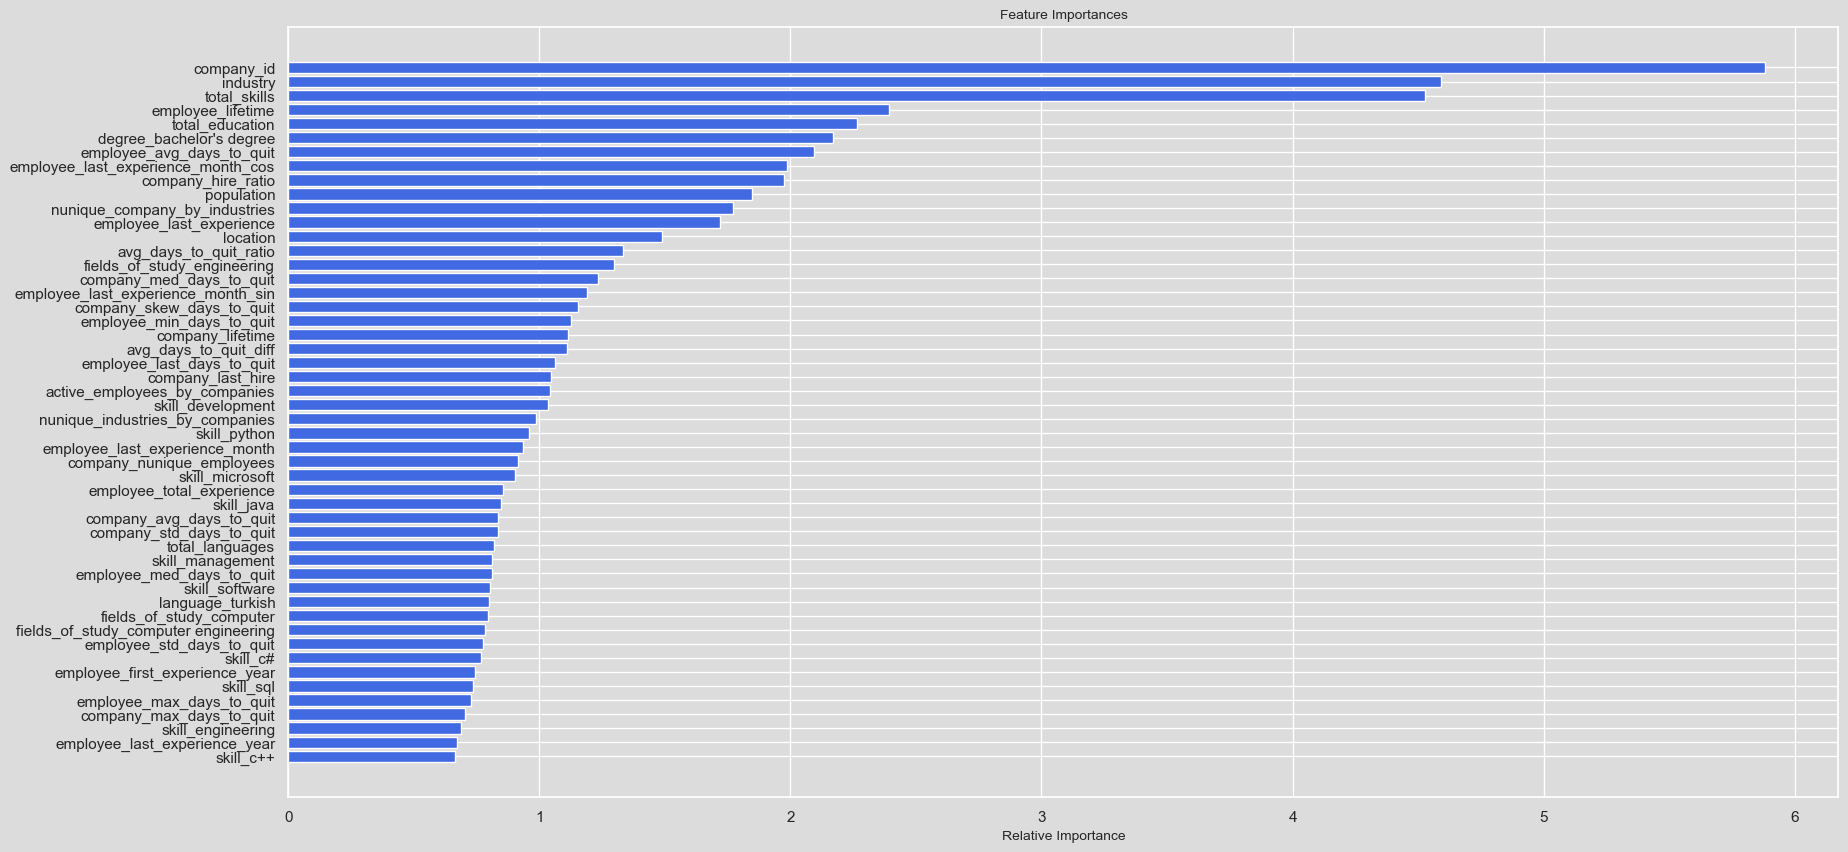

fold accuracy: 0.7863608931804466
-----------------------------------| Fold 2 |-----------------------------------
train: (46391, 301)
val: (6628, 301)
0:	learn: 0.6444785	test: 0.6302052	best: 0.6302052 (0)	total: 180ms	remaining: 15m 2s
250:	learn: 0.7742450	test: 0.7466807	best: 0.7468316 (246)	total: 35.1s	remaining: 11m 4s
500:	learn: 0.8133259	test: 0.7596560	best: 0.7602595 (493)	total: 1m 10s	remaining: 10m 36s
750:	learn: 0.8524714	test: 0.7658419	best: 0.7659928 (748)	total: 1m 47s	remaining: 10m 6s
1000:	learn: 0.8896338	test: 0.7723295	best: 0.7723295 (1000)	total: 2m 23s	remaining: 9m 31s
1250:	learn: 0.9138195	test: 0.7777610	best: 0.7777610 (1250)	total: 2m 59s	remaining: 8m 57s
1500:	learn: 0.9328318	test: 0.7815329	best: 0.7816838 (1499)	total: 3m 35s	remaining: 8m 22s
1750:	learn: 0.9479425	test: 0.7850030	best: 0.7863609 (1701)	total: 4m 11s	remaining: 7m 47s
2000:	learn: 0.9577289	test: 0.7871153	best: 0.7883223 (1876)	total: 4m 48s	remaining: 7m 11s
2250:	learn: 0.

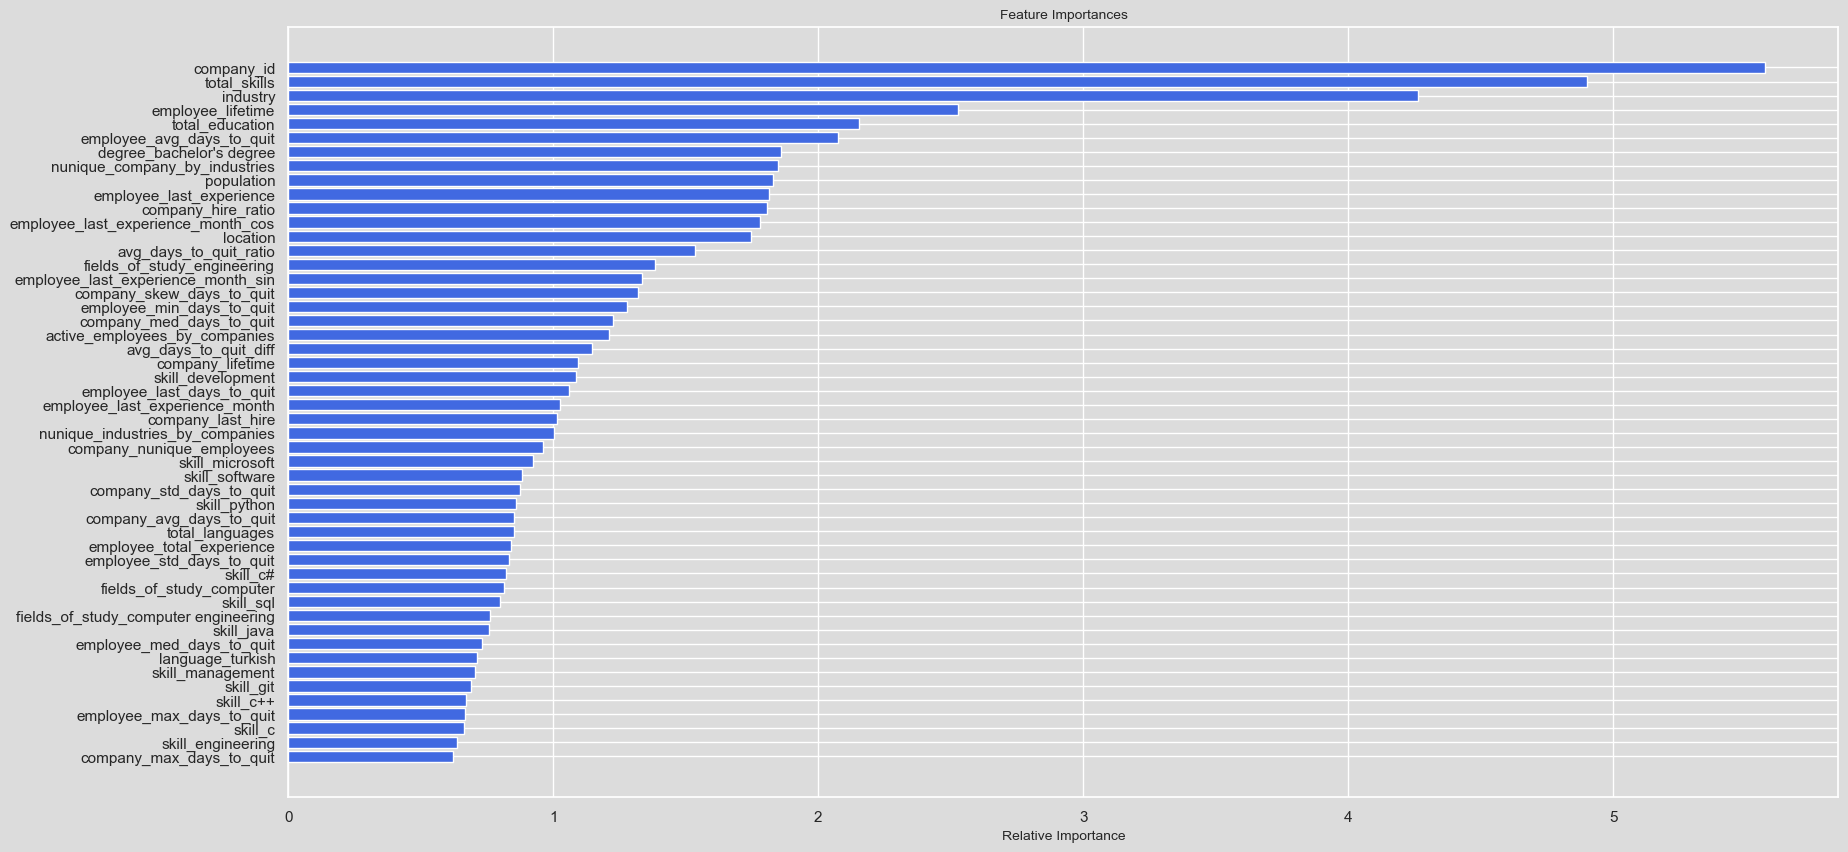

fold accuracy: 0.7925467712733857
-----------------------------------| Fold 3 |-----------------------------------
train: (46391, 301)
val: (6628, 301)
0:	learn: 0.6457718	test: 0.6368437	best: 0.6368437 (0)	total: 199ms	remaining: 16m 33s
250:	learn: 0.7790951	test: 0.7352142	best: 0.7359686 (245)	total: 34.8s	remaining: 10m 57s
500:	learn: 0.8164299	test: 0.7483404	best: 0.7483404 (485)	total: 1m 10s	remaining: 10m 34s
750:	learn: 0.8569766	test: 0.7584490	best: 0.7590525 (736)	total: 1m 46s	remaining: 10m 4s
1000:	learn: 0.8910996	test: 0.7676524	best: 0.7676524 (992)	total: 2m 23s	remaining: 9m 31s
1250:	learn: 0.9164924	test: 0.7715751	best: 0.7726313 (1244)	total: 3m	remaining: 8m 59s
1500:	learn: 0.9350736	test: 0.7750453	best: 0.7750453 (1402)	total: 3m 37s	remaining: 8m 26s
1750:	learn: 0.9490634	test: 0.7785154	best: 0.7788171 (1725)	total: 4m 14s	remaining: 7m 51s
2000:	learn: 0.9606389	test: 0.7812311	best: 0.7818346 (1976)	total: 4m 50s	remaining: 7m 15s
2250:	learn: 0.969

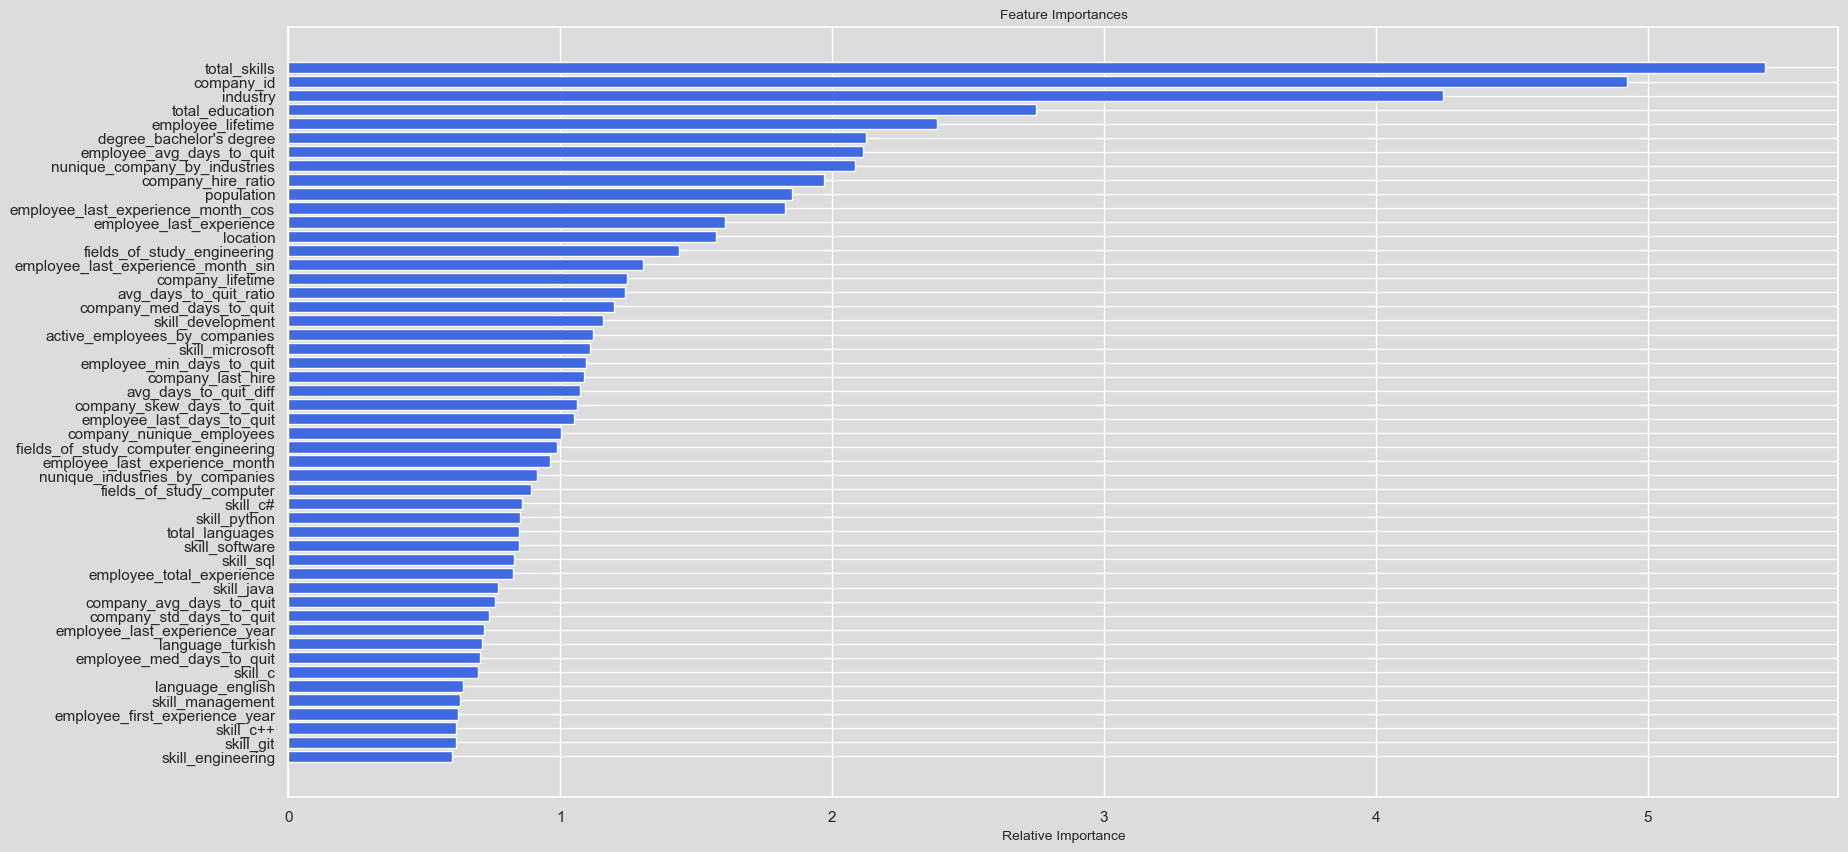

fold accuracy: 0.7904345202172601
-----------------------------------| Fold 4 |-----------------------------------
train: (46392, 301)
val: (6627, 301)
0:	learn: 0.6398517	test: 0.6434284	best: 0.6434284 (0)	total: 183ms	remaining: 15m 17s
250:	learn: 0.7801561	test: 0.7433228	best: 0.7436246 (242)	total: 33s	remaining: 10m 24s
500:	learn: 0.8212407	test: 0.7534329	best: 0.7537347 (491)	total: 1m 7s	remaining: 10m 2s
750:	learn: 0.8593292	test: 0.7614305	best: 0.7617323 (711)	total: 1m 41s	remaining: 9m 33s
1000:	learn: 0.8931066	test: 0.7730496	best: 0.7730496 (1000)	total: 2m 15s	remaining: 9m
1250:	learn: 0.9164296	test: 0.7778784	best: 0.7780293 (1249)	total: 2m 49s	remaining: 8m 29s
1500:	learn: 0.9363899	test: 0.7811981	best: 0.7811981 (1500)	total: 3m 24s	remaining: 7m 56s
1750:	learn: 0.9502285	test: 0.7819526	best: 0.7831598 (1593)	total: 3m 58s	remaining: 7m 22s
2000:	learn: 0.9618038	test: 0.7854233	best: 0.7860269 (1967)	total: 4m 33s	remaining: 6m 49s
2250:	learn: 0.970490

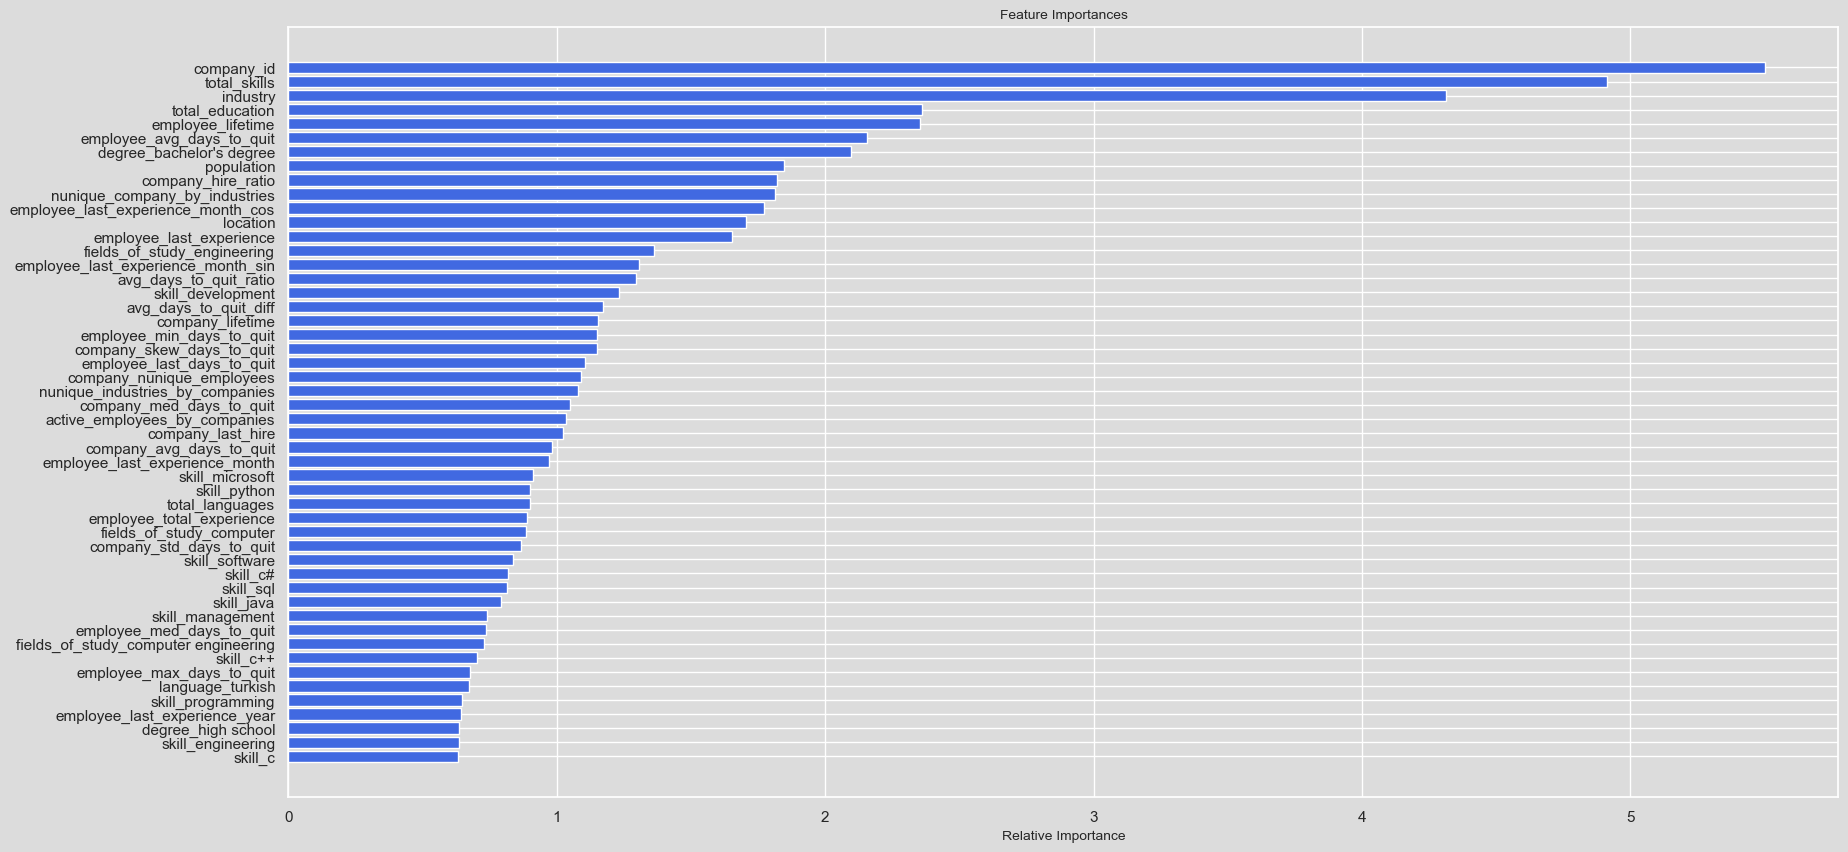

fold accuracy: 0.7896484080277653
-----------------------------------| Fold 5 |-----------------------------------
train: (46392, 301)
val: (6627, 301)
0:	learn: 0.6451328	test: 0.6392033	best: 0.6392033 (0)	total: 162ms	remaining: 13m 29s
250:	learn: 0.7751121	test: 0.7452844	best: 0.7458880 (247)	total: 35s	remaining: 11m 1s
500:	learn: 0.8158734	test: 0.7593179	best: 0.7605251 (494)	total: 1m 10s	remaining: 10m 37s
750:	learn: 0.8562468	test: 0.7659574	best: 0.7665610 (748)	total: 1m 47s	remaining: 10m 7s
1000:	learn: 0.8927832	test: 0.7716916	best: 0.7725970 (990)	total: 2m 23s	remaining: 9m 33s
1250:	learn: 0.9175289	test: 0.7780293	best: 0.7789347 (1241)	total: 2m 59s	remaining: 8m 58s
1500:	learn: 0.9346439	test: 0.7814999	best: 0.7816508 (1498)	total: 3m 36s	remaining: 8m 24s
1750:	learn: 0.9485256	test: 0.7813490	best: 0.7833107 (1584)	total: 4m 12s	remaining: 7m 48s
2000:	learn: 0.9598207	test: 0.7828580	best: 0.7837634 (1990)	total: 4m 48s	remaining: 7m 12s
2250:	learn: 0.96

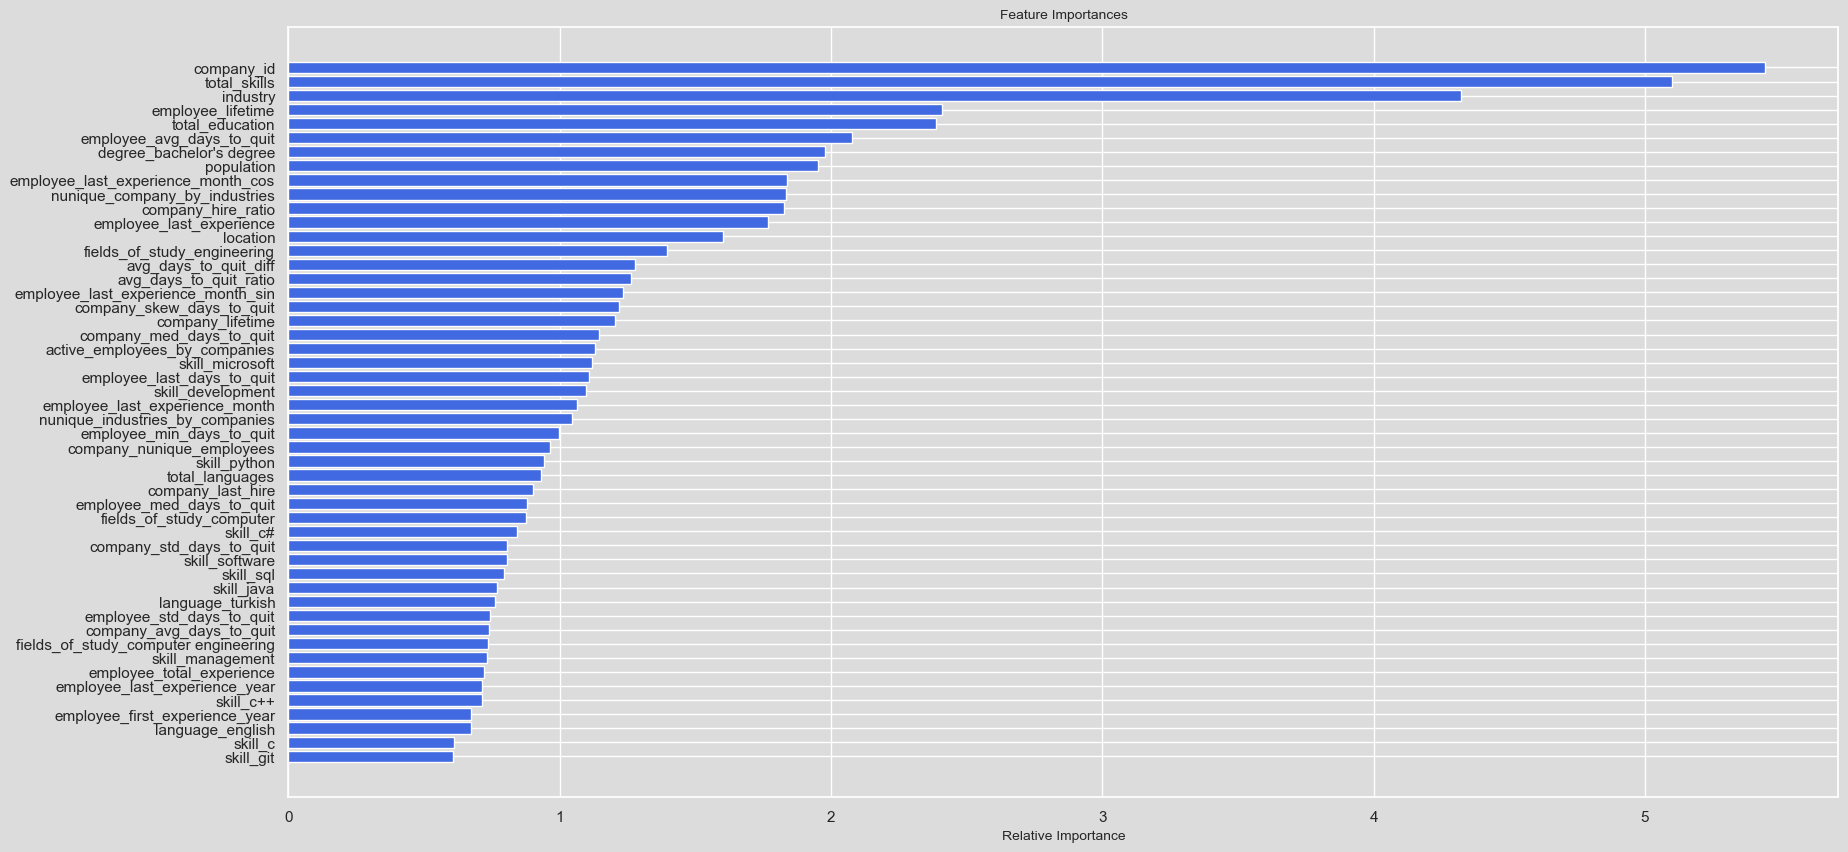

fold accuracy: 0.7894975101856043
-----------------------------------| Fold 6 |-----------------------------------
train: (46392, 301)
val: (6627, 301)
0:	learn: 0.6417055	test: 0.6363362	best: 0.6363362 (0)	total: 178ms	remaining: 14m 48s
250:	learn: 0.7759743	test: 0.7406066	best: 0.7410593 (249)	total: 34.7s	remaining: 10m 57s
500:	learn: 0.8151621	test: 0.7552437	best: 0.7555455 (499)	total: 1m 12s	remaining: 10m 47s
750:	learn: 0.8549750	test: 0.7642976	best: 0.7649012 (724)	total: 1m 48s	remaining: 10m 14s
1000:	learn: 0.8917270	test: 0.7706353	best: 0.7710880 (991)	total: 2m 24s	remaining: 9m 39s
1250:	learn: 0.9154380	test: 0.7757658	best: 0.7765203 (1243)	total: 3m 1s	remaining: 9m 3s
1500:	learn: 0.9340835	test: 0.7801418	best: 0.7805945 (1490)	total: 3m 38s	remaining: 8m 30s
1750:	learn: 0.9480514	test: 0.7818017	best: 0.7825562 (1741)	total: 4m 16s	remaining: 7m 55s
2000:	learn: 0.9590447	test: 0.7836125	best: 0.7849706 (1976)	total: 4m 52s	remaining: 7m 18s
2250:	learn: 0.

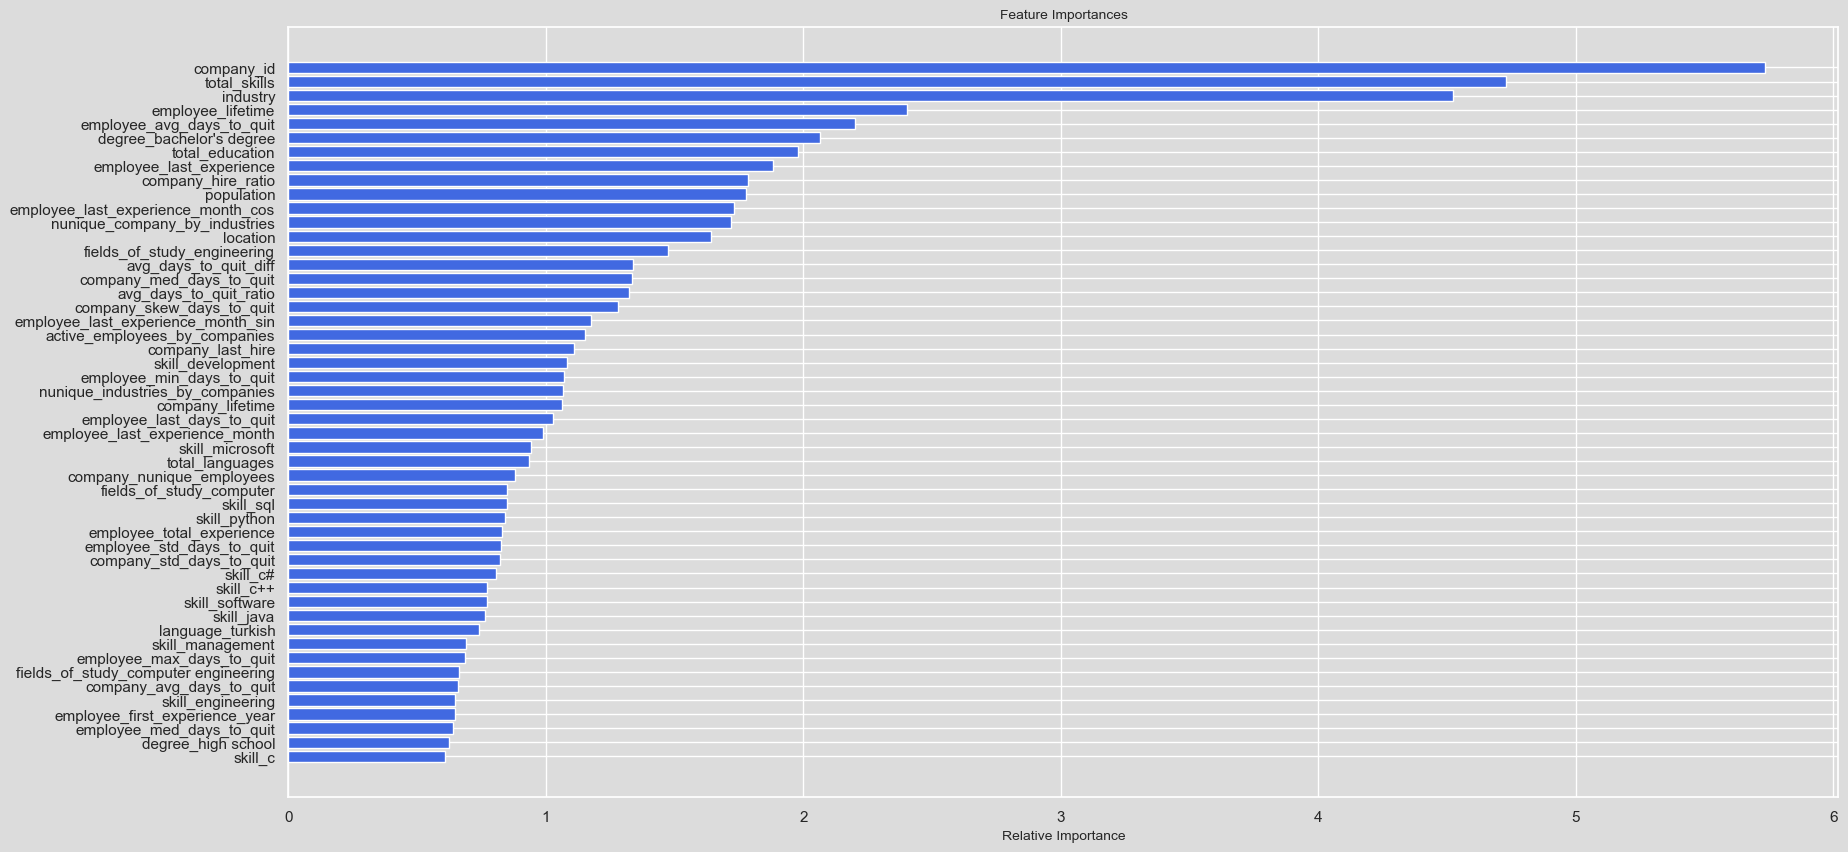

fold accuracy: 0.7870831447110306
-----------------------------------| Fold 7 |-----------------------------------
train: (46392, 301)
val: (6627, 301)
0:	learn: 0.6433221	test: 0.6395051	best: 0.6395051 (0)	total: 166ms	remaining: 13m 48s
250:	learn: 0.7793154	test: 0.7443791	best: 0.7445300 (249)	total: 35s	remaining: 11m 1s
500:	learn: 0.8183092	test: 0.7523766	best: 0.7531311 (483)	total: 1m 11s	remaining: 10m 42s
750:	learn: 0.8556001	test: 0.7587144	best: 0.7594688 (712)	total: 1m 47s	remaining: 10m 10s
1000:	learn: 0.8918132	test: 0.7679191	best: 0.7692772 (988)	total: 2m 24s	remaining: 9m 35s
1250:	learn: 0.9153518	test: 0.7753131	best: 0.7768221 (1196)	total: 3m	remaining: 9m 1s
1500:	learn: 0.9347086	test: 0.7808963	best: 0.7818017 (1485)	total: 3m 37s	remaining: 8m 26s
1750:	learn: 0.9487412	test: 0.7860269	best: 0.7870831 (1731)	total: 4m 13s	remaining: 7m 50s
2000:	learn: 0.9604027	test: 0.7876867	best: 0.7890448 (1967)	total: 4m 50s	remaining: 7m 14s
2250:	learn: 0.968593

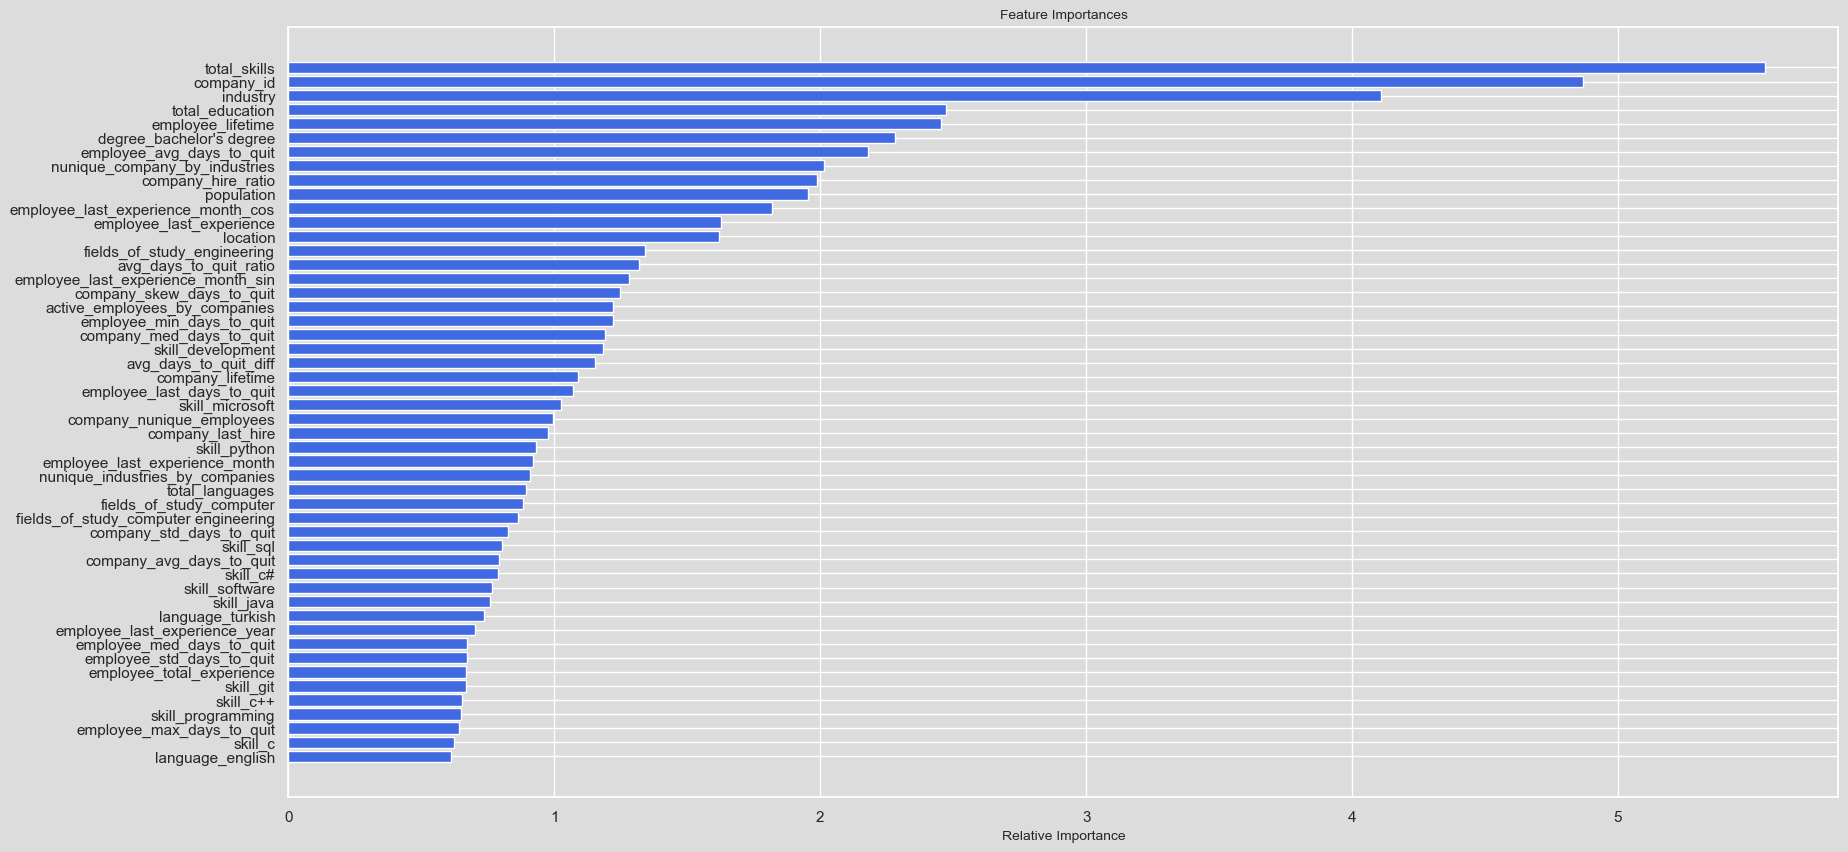

fold accuracy: 0.7953825260298778
-----------------------------------| Fold 8 |-----------------------------------
train: (46392, 301)
val: (6627, 301)
0:	learn: 0.6442706	test: 0.6327147	best: 0.6327147 (0)	total: 212ms	remaining: 17m 38s
250:	learn: 0.7819667	test: 0.7404557	best: 0.7415120 (247)	total: 35.4s	remaining: 11m 9s
500:	learn: 0.8192792	test: 0.7517730	best: 0.7519239 (482)	total: 1m 12s	remaining: 10m 54s
750:	learn: 0.8600405	test: 0.7627886	best: 0.7632413 (742)	total: 1m 49s	remaining: 10m 19s
1000:	learn: 0.8962752	test: 0.7685227	best: 0.7688245 (994)	total: 2m 25s	remaining: 9m 42s
1250:	learn: 0.9206975	test: 0.7748604	best: 0.7748604 (1248)	total: 3m 2s	remaining: 9m 6s
1500:	learn: 0.9385670	test: 0.7793874	best: 0.7795383 (1479)	total: 3m 38s	remaining: 8m 29s
1750:	learn: 0.9519098	test: 0.7816508	best: 0.7822544 (1731)	total: 4m 15s	remaining: 7m 53s
2000:	learn: 0.9620840	test: 0.7830089	best: 0.7834616 (1990)	total: 4m 53s	remaining: 7m 19s
2250:	learn: 0.9

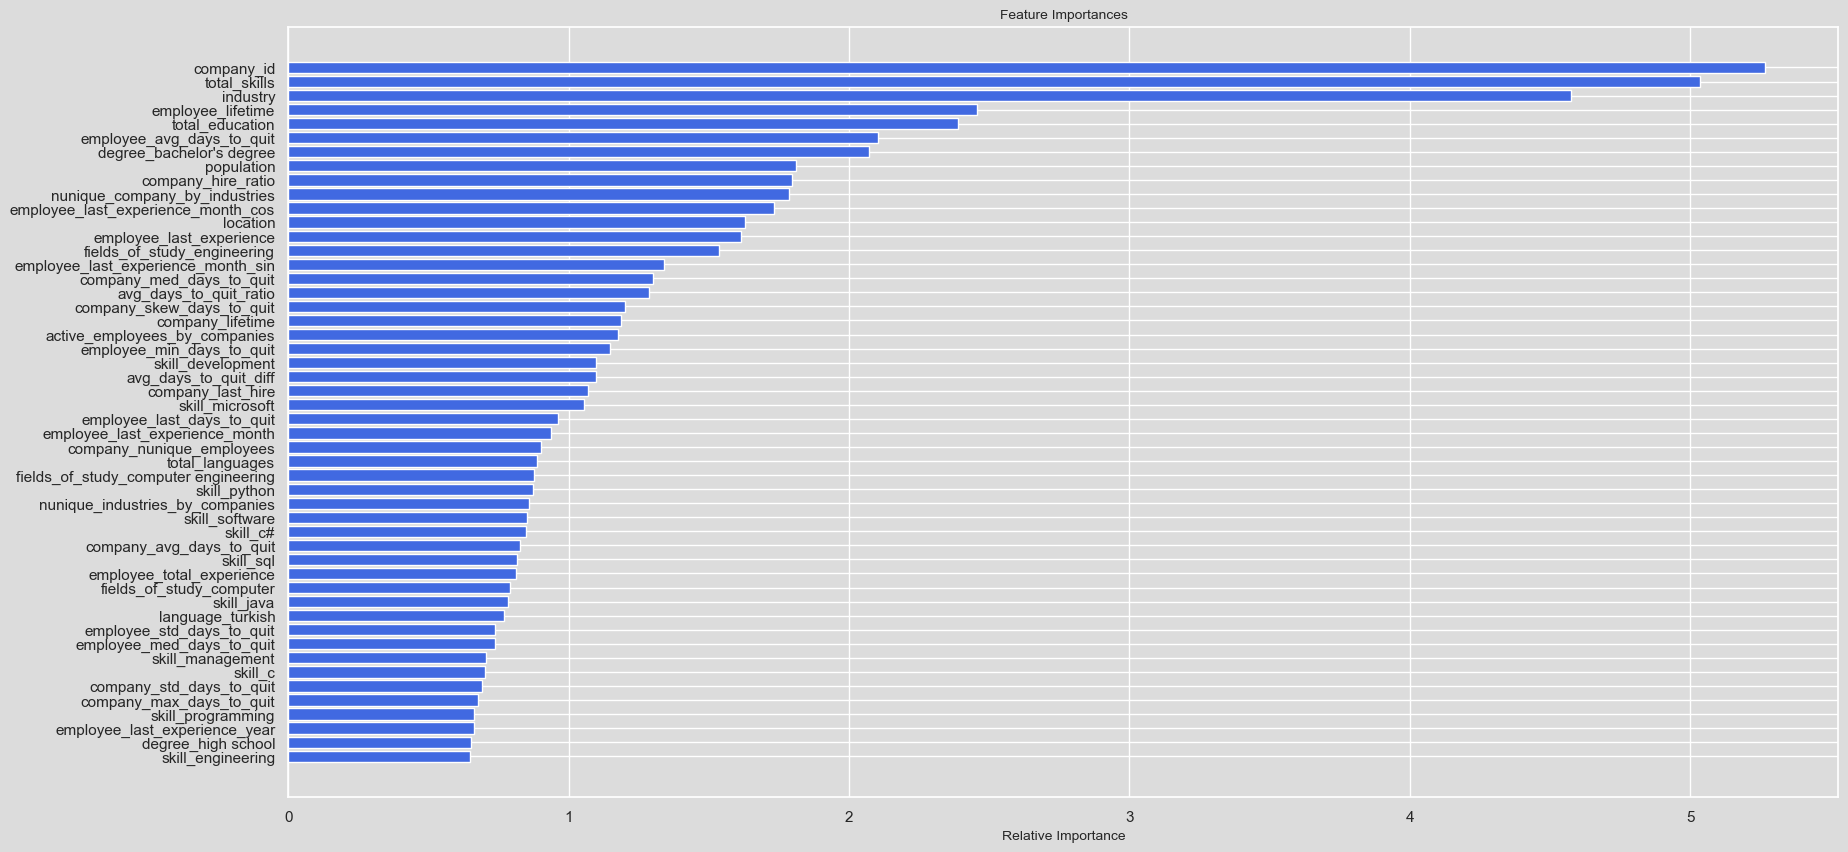

fold accuracy: 0.7891957145012827
accuracy: 0.7900186725513495
folds avg accuracy: 0.7900186860158316


In [ ]:
cat2_scores, cat2_train_scores = get_model_scores(cat2, skf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #accuracy: 0.7886040853279013

accuracy: 0.7922631509458873 <br>
folds avg accuracy: 0.7922632031969215

In [13]:
thr = 0.499
score_ = list()
w_range = np.arange(0.02, 0.98, 0.02)
for i in w_range:
    score_.append(
        accuracy_score(
            train_set[target],
            np.where(
                cat2_train_scores[:, 1] * i + xgb2_train_scores[:, 1] * (1 - i)
                >= thr,
                1,
                0,
            ),
        )
    )

max_score = np.max(score_)
print(f"max score: {max_score}")
w1 = round(w_range[np.argmax(score_)], 2)
w2 = round(1-w1, 2)
print(f"weight w highest accuracy: {w1} - {w2}")

max score: 0.7926969576944114
weight w highest accuracy: 0.5 - 0.5


In [14]:
sub[target] = np.where((cat2_scores[:, 1] * 0.5) + (xgb2_scores[:, 1] * 0.5)  >= thr, 1, 0)

#sub[target] = np.where(test_scores_xgb[:, 1]  >= 0.499, 1, 0)
print(sub[target].value_counts())

sub.head(10)

0    9103
1    4152
Name: moved_after_2019, dtype: int64


,user_id,moved_after_2019
0,17449,0
1,33967,1
2,2110,0
3,55082,0
4,37165,0
5,42841,1
6,8407,0
7,17053,0
8,24437,1
9,44394,0


In [15]:
sub.to_csv(f'../submissions/ensemble_cat_xgb_{round(max_score, 6)}.csv', index = False)

In [ ]:
#sub[target] = 0

#sub.to_csv(f'../submissions/dummy_submission.csv', index = False)

In [17]:
#sub1 = pd.read_csv('../submissions/ensemble_cat_xgb_v23.csv')
#sub2 = pd.read_csv('../submissions/ensemble_cat_xgb_v24.csv')
#sub3 = pd.read_csv('../submissions/ensemble_cat_xgb_v25.csv')
#sub4 = pd.read_csv('../submissions/ensemble_cat_xgb_v30.csv')
#sub[target] = np.where((sub1[target] * 0.5) + (sub2[target] * 0.25) + (sub3[target] * 0.25) >= 0.5, 1, 0)
#sub.to_csv(f'../submissions/all_ensemble_v2.csv', index = False)

In [ ]:
#cat1_scores, cat1_train_scores = get_model_scores(cat1, skf, train_set, test_set, 'moved_after_2019', config.n_folds, True) #accuracy: 0.7886040853279013

#train_scores_xgb = np.zeros((train_set.shape[0], 2))
#test_scores_xgb = np.zeros((test_set.shape[0], 2))
#seeds = [42, 43, 44]
#
#for s in seeds:
#    skf = StratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=s)
#    xgb1_scores, xgb1_train_scores = get_model_scores(xgb1, skf, train_set, test_set, 'moved_after_2019', config.n_folds, False)
#    test_scores_xgb += xgb1_scores / len(seeds)
#    train_scores_xgb += xgb1_train_scores / len(seeds)


#cat1 = CatBoostClassifier(
#    **{
#        "one_hot_max_size": 120,
#        "depth": 9,
#        'learning_rate': 0.02245,
#        "boosting_type": "Plain",
#        "bootstrap_type": "MVS",
#        "iterations": 5000,
#        "random_state": config.seed,
#        "cat_features": cat_features,
#        "eval_metric": "Accuracy",
#        "allow_writing_files": False,
#        "verbose": False,
#    }
#)
#
#cat2 = CatBoostClassifier(
#    **{
#        "one_hot_max_size": 60,
#        "depth": 10,
#        'learning_rate': 0.021,
#        "boosting_type": "Plain",
#        "bootstrap_type": "Bernoulli",
#        'subsample': 0.82,
#        "iterations": 5000,
#        "random_state": config.seed,
#        "cat_features": cat_features,
#        "eval_metric": "Accuracy",
#        "allow_writing_files": False,
#        "verbose": False,
#    }
#)
#
#xgb1 = XGBClassifier(
#    **{
#        "max_depth": 9,
#        'subsample': 0.86,
#        'learning_rate': 0.013,
#        "colsample_bytree": 0.7243331,
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'tree_method': 'hist',
#        'n_estimators': 5000
#    }
#)
#
#xgb2 = XGBClassifier(
#    **{
#    'max_depth': 7,
#    'min_child_weight': 4,
#    'learning_rate': 0.025550390755004846,
#    'subsample': 0.9300942544989869,
#    'tree_method': 'hist',
#    'enable_categorical': True,
#    'random_state': 42,
#    'n_estimators': 5000,
#    'objective': 'binary:logistic'
#    }
#)
#
#xgb3 = XGBClassifier(
#    **{
#    'max_depth': 8,
#    'min_child_weight': 5,
#    'learning_rate': 0.017185833980170477,
#    'subsample': 0.1659232148768028,
#    'tree_method': 'hist',
#    'enable_categorical': True,
#    'random_state': 42,
#    'n_estimators': 5000,
#    'objective': 'binary:logistic'
#    }
#)
#
#xgb4 = XGBClassifier(
#    **{
#        "max_depth": 9,
#        'subsample': 0.87,
#        'learning_rate': 0.028,
#        'min_child_weight': 6,
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'tree_method': 'hist',
#        'n_estimators': 5000
#    }
#)
#
#xgb5 = XGBClassifier(
#    **{
#        "max_depth": 8,
#        'learning_rate': 0.025,
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'tree_method': 'hist',
#        'n_estimators': 5000,
#        'min_child_weight': 5,
#        'gamma': 0.11
#    }
#)

In [16]:
#cat1_v2 = CatBoostClassifier(
#    **{
#        "one_hot_max_size": 150,
#        "depth": 12,
#        'learning_rate': 0.02,
#        "boosting_type": "Plain",
#        "bootstrap_type": "MVS",
#        "iterations": 4000,
#        "random_state": config.seed,
#        "cat_features": cat_features,
#        "eval_metric": "Accuracy",
#        "allow_writing_files": False,
#        "verbose": False,
#    }
#)
#
#cat2 = CatBoostClassifier(
#    **{
#        "one_hot_max_size": 180,
#        "depth": 12,
#        'learning_rate': 0.02,
#        "boosting_type": "Plain",
#        "bootstrap_type": "Bernoulli",
#        'subsample': 0.85,
#        "iterations": 5000,
#        "random_state": config.seed,
#        "cat_features": cat_features,
#        "eval_metric": "Accuracy",
#        "allow_writing_files": False,
#        "verbose": False,
#    }
#)
#
#xgb1 = XGBClassifier(
#    **{
#        "max_depth": 12,
#        'subsample': 0.84,
#        'learning_rate': 0.012,
#        #"max_cat_to_onehot": 170,
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'tree_method': 'hist',
#        'n_estimators': 5000
#    }
#)
#
##optuna accuracy: 0.7913200717625333
#xgb2 = XGBClassifier(
#    **{
#        'max_depth': 10,
#        'colsample_bylevel': 0.5278208423543558,
#        'learning_rate': 0.013365198710298768,
#        'subsample': 0.8970592179744503,
#        'tree_method': 'hist',
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'n_estimators': 5000,
#        'objective': 'binary:logistic'
#    }
#)
#
#xgb2 = XGBClassifier(
#    **{
#        'max_depth': 8,
#        'colsample_bytree': 0.9022539835244943,
#        'learning_rate': 0.029665791085370145,
#        'subsample': 0.10503841501004575,
#        'tree_method': 'hist',
#        'enable_categorical': True,
#        'random_state': 42,
#        'n_estimators': 5000,
#        'objective': 'binary:logistic',
#        'gamma': 2.846243837248615e-05
#    }
#)
#
#xgb1_v2 = XGBClassifier(
#    **{
#        "max_depth": 12,
#        'subsample': 0.84,
#        'learning_rate': 0.012,
#        #"max_cat_to_onehot": 170,
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'tree_method': 'hist',
#        'n_estimators': 5000
#    }
#)
#
#xgb4 = XGBClassifier(
#    **{
#        "max_depth": 13,
#        'subsample': 0.88,
#        'learning_rate': 0.018,
#        'colsample_bylevel': 0.72,
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'tree_method': 'hist',
#        'n_estimators': 5000
#    }
#)
#
##optuna accuracy: 0.791263431000755
#xgb7 = XGBClassifier(
#    **{
#        'max_depth': 13,
#        'colsample_bylevel': 0.5015371836125226,
#        'learning_rate': 0.01378678089792197,
#        'subsample': 0.8887196385241469,
#        'tree_method': 'hist',
#        'enable_categorical': True,
#        'random_state': config.seed,
#        'n_estimators': 5000,
#        'objective': 'binary:logistic'
#    }
#)